## 決定木のアンサンブル法

`アンサンブル法`とは複数の機械学習モデルを組み合わせることで、より強力なモデルを構築する手法。様々なデータセットに対するクラス分類や回帰に関して有効だとわかっているアンサンブル法は以下の二つである
    
    - ランダムフォレスト
    - 勾配ブースティング決定木

### ランダムフォレスト

少しづつ異なる決定木を沢山集めたもの。ランダムフォレストは、個々の決定木は比較的うまく予測出来ているが、一部のデータに対して過剰適合してしまっているという考えに基づいている。それぞれ異なった方向に過剰適合した決定木を沢山作れば、その結果の平均を取ることで過剰適合の度合いを減らすことが出来る。

ランダムフォレストは個々の決定木を互いに異なるように、決定木の構築過程で乱数を導入していることからついている。導入先は以下の二つである。

    - 決定木を作る為のデータポイントの選択方法
    - 分枝テストに用いる特徴を選択する方法

### ランダムフォレストの構築

ランダムフォレストを構築するには、構築する決定木の数を決めなければならない。

```
    - RandomForestRegressor
    - RandomForestClassifier
```
のn_estimatorsのパラメータ。

1. 決定木を作るには、まずデータから`ブートストラップサンプリング`を行う。ブートストラップサンプリングとはn_samples個のデータポイントから、交換ありでデータポイントをランダムにn_samples回選び出す手法である(復元抽出)

2. この新しいデータセットを用いて決定木を作る。個々のノードで最適なテストを選ぶのではなく、特徴量のサブセットをランダムに選び、その特徴量を使うものの中から最適なテストを選ぶ。特徴サブセットの大きさはmax_featuresで制御できる。この特徴量のサブセットの選択は、個々のノードで独立に繰り返し行われる。これによって決定木の個々のノードが異なる特徴量のサブセットを使って決定を行う様になる。    ブートストラップサンプリングによって、ランダムフォレストの中の個々の決定木が少しずつ違うデータセットに対して構築される。さらに個々のノードでの特徴量の選択によって、それぞれの決定木は異なる特徴量のサブセットに対して分割を行うことになる。この機構が組み合わさることで、ランダムフォレスト中の個々の決定木が異なるものになる。この過程で重要なのがmax_featuresパラメータ。max_featuresをn_featuresに設定すると、それぞれの分岐でデータセット中のすべての特徴量を見ることになり、特徴量選択時の乱数性はなくなる（ブートストラッぷサンプリングによる乱数性は残る）。max_featuresを1にすると、分岐時に使う特徴量選択には全く選択肢がないことになり、ランダムに選ばれたある特徴量に対してスレショルドを探すだけになる。したがってmax_featuresを大きくすると、ランダムフォレスト中の決定木が似た様なものになり、最も識別性の高い特徴量を使うので、訓練データに容易に適合できる。max_featuresを小さくするとランダムフォレスト中の決定木は大幅に異なるものとなるが、それぞれの決定木を深く作らないとデータに適合できない。

3. 全ての決定木について予測を行い、回帰の場合にはこれらの結果の平均値を最終的な予測として用いる。クラス分類の場合には「ソフト投票」戦略が用いられる。それぞれの決定木が出したラベルの確率を平均し、最も確率の高いラベルが予測値になる。

- make_moonsデータセットに適応

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

- ５つのランダム化された決定木による決定境界と、それらを平均して得られた決定境界

それぞれの決定木は、一部の点について分類に失敗している。これはブートストラップサンプリングで一部のデータを選んでいるのが理由。ランダムフォレストはここのどの決定木よりも過剰適合が少ない。実際は数百から数千の決定木を使うので決定境界はなめらかになる。

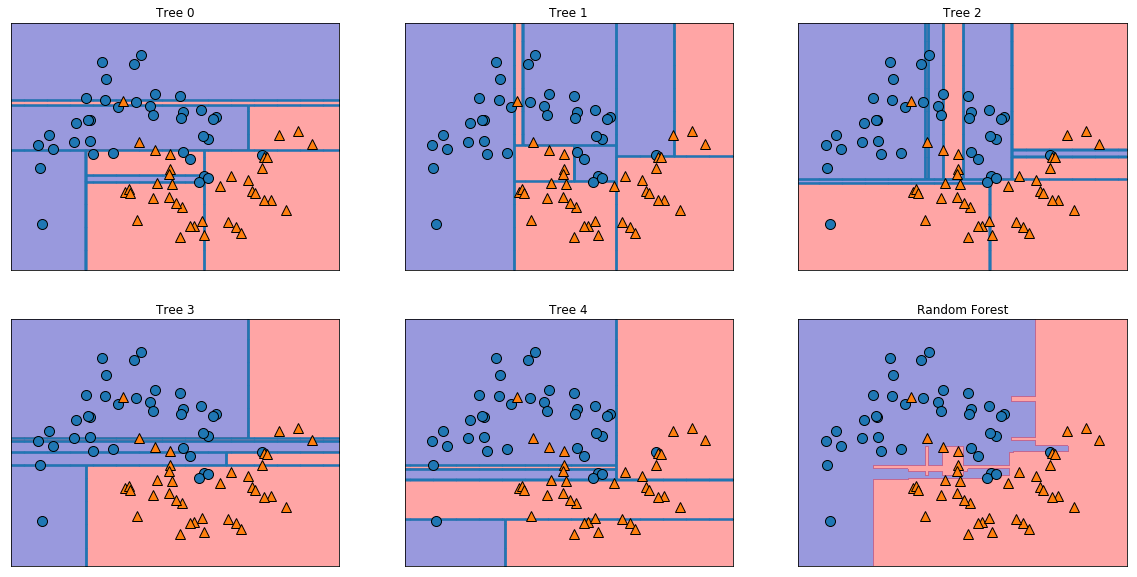

In [7]:
import mglearn
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.show()

In [10]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0) #n_estimators：作る決定木の数
forest.fit(X_train, y_train)

print("Accuracy on training set:{:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set:{:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set:0.998
Accuracy on test set:0.944


In [12]:
import numpy as np

def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

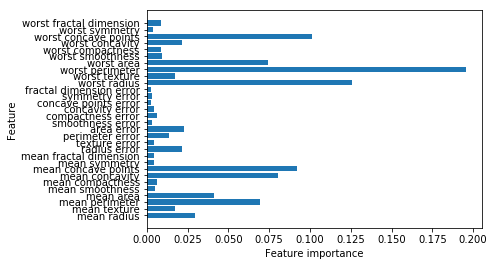

In [13]:
plot_feature_importances_cancer(forest)
plt.show()

回帰でも分類でもランダムフォレストが現在最も広く使われている機械学習手法で、非常に強力でチューニングも容易でデータスケール変換も必要ない。決定木の欠点を補っている。あえて決定木を使う理由は決定プロセスがわかりやすいくらい。大きいデータセットにランダムフォレストは時間がかかるのでcpuコアを並列するn_jobsパラメータが使える。random_stateを設定するとランダムシードが変わるためにモデルが変わる。再現するには固定する必要がある。    
非常に高次元で疎なデータにはうまく機能しない傾向にあり、線形モデルの方が適してる。ランダムフォレストは線形モデルより多くのメモリを消費するし、訓練も予測も遅い。

### ランダムフォレストの利点, 欠点, パラメータ

- パラメータ

```
n_estimators: 決定木の数。より多くの決定木の平均を取るため、大きければ大きいほどよい。過剰適合が低減されてアンサンブルが効く。増やすごとにメモリ量やレスポンスも増える。
max_features: 決定木の分岐時の選択可能性のある特徴量。個々の決定木の乱数性を決定すると共に、小さくなると過剰適合が低減する。一般的にはデフォルト値でよい
max_depth: 事前枝刈り
```

- 利点
    - 強い
- 欠点
    - 予測のプロセスが分かりにくい